# Automatic Reward Shaping from Confounded Offline Data
This notebook is based on our ICML 25 [paper](https://openreview.net/forum?id=Hu7hUjEMiW&referrer=%5BAuthor%20Console%5D(%2Fgroup%3Fid%3DICML.cc%2F2025%2FConference%2FAuthors%23your-submissions)).
Also see the Techical Report version [here](https://causalai.net/r123.pdf).

The task is to learn a potential function automatically from offline data to be used in Potential Based Reward Shaping (PBRS). The new reward function after reward shaping is defined to be,
$$
Y' = Y + \gamma\phi(s') - \phi(s)
$$
where $Y$ is the original reward signal and $Y'$ is the one after shaping. $\phi(\cdot)$ is the potential function we aim to learn automatically from offline datasets.

Intuitively, one can use the optimal state values as the potential function. And if the provided offline dataset is generated by a good enough policy, one can directly take the average cumulative return as the state value estimations. However, when the offline dataset is confounded or the data generating policy is sub-optimal, such naive estimations are highly biased and could mislead the policy training. See example 1&2 in the paper for more details.

In this work, we use causal bounds to estimate an upper bound on the optimal interventional
state values. Then, we take the estimated upper value bound as the potential function to train our online policy learner, Q-UCB.

## Environment Definition and Data Generation
In this notebook, we will replicate our experiment results in environment WindyLavaCross (hard), corresponding to Fig. 3(c) and Fig. 4(c).

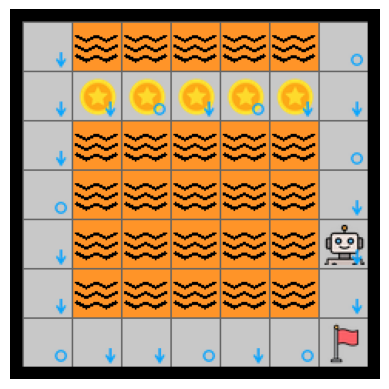

In [1]:
import matplotlib.pyplot as plt

from causal_gym.core import Task
from causal_rl.algo.reward_shaping.calculate_values import *
# First let's get a brief overview of the environment
env_name = 'Custom-LavaCrossing-extreme-v0'
# Initialize the environment
env = gym.make(
    env_name, 
    agent_pov=False, 
    render_mode='rgb_array', 
    highlight=False, 
    **KWARGS[env_name]
)
# We have to use 'cool' as the learning regime since we need do for online learning
# and see for collecting offline data.
windy_env = MiniGridActionRemapWrapper(WindyMiniGridPCH(
    env=env, 
    show_wind=True, 
    wind_dist=WIND_DIST[env_name],
    task=Task(learning_regime='cool'), 
))
# Starting position is randomized to help data sampling
# Wind direction is denoted as blue arrows. 
# If no wind, a hollow circle is shown.
# The goal of the agent is to reach the red flag without 
# falling into the lava. Whenever possible, 
# getting some coins is also prefered.
state, info = windy_env.reset()
obs = windy_env.render()
plt.imshow(obs)
plt.axis('off')
plt.show()

In [2]:
from causal_gym.core import Task
from causal_rl.algo.reward_shaping.calculate_values import *

# Define behavioral policy
BEHAVIORAL = {
    'Nowind-Empty-8x8-v0': {
        'good': good_bpolicy_emptyworld,
        'bad': lambda s, w: good_bpolicy_emptyworld(s, w) if np.random.rand() > .5 else np.random.choice(5),
        'random': lambda s, w: np.random.choice(5),
    },
    'MiniGrid-Empty-8x8-v0': {
        'good': good_bpolicy_emptyworld,
        'bad': lambda s, w: good_bpolicy_emptyworld(s, w) if np.random.rand() > .5 else np.random.choice(5),
        'random': lambda s, w: np.random.choice(5),
    },
    'Custom-LavaCrossing-easy-v0': {
        'good': good_bpolicy_lavacross,
        'bad': bad_bpolicy_lavacross,
        'random': lambda s, w: np.random.choice(5)
    },
    'Custom-LavaCrossing-hard-v0': {
        'good': good_bpolicy_lavacross_hard,
        'bad': bad_bpolicy_lavacross_hard,
        'random': lambda s, w: np.random.choice(5)
    },
    'Custom-LavaCrossing-extreme-v0': {
        'good': good_bpolicy_lavacross_extreme,
        'bad': bad_bpolicy_lavacross_extreme,
        'random': lambda s, w: np.random.choice(5)
    },
    'Custom-LavaCrossing-maze-v0': {
        'good': good_bpolicy_lavacross_maze,
        'bad': bad_bpolicy_lavacross_maze,
        'bad2': bad_bpolicy_lavacross_maze2
    },
    'Custom-LavaCrossing-maze-complex-v0': {
        'good': better_bpolicy_lavacross_maze_complex,
        'bad': good_bpolicy_lavacross_maze,
        'bad2': bad_bpolicy_lavacross_maze_complex
    }
}

env_name = 'Custom-LavaCrossing-extreme-v0'
for SEED in SEEDS:
    print('\n=======================================\n')
    print(f'Env: {env_name} Seed: {SEED}')
    # Calculate optimal interventional policy space state value
    opt_values, opt_qvalues = value_iteration(windy_env)
    print(f'Opt state values of {env_name}')
    print(np.transpose(opt_values))
    save_values(opt_values, f'OPTV-{env_name}-{SEED}')
    save_values(opt_qvalues, f'OPTQ-{env_name}-{SEED}')
    print('------------------------')

    bounds = []
    mixed_dataset = []
    for policy_name, bpolicy in BEHAVIORAL[env_name].items():
        dataset, behavioral_values = gen_dataset(windy_env, bpolicy, seed=SEED, length=100000)
        mixed_dataset.extend(dataset)
        print(f'{policy_name} behavioral policy values')
        print(np.transpose(behavioral_values))
        save_values(behavioral_values, f'BEV-{policy_name}-{env_name}-{SEED}')
        print('------------------------')
        bound, state_count = approx_opt_value_upper_bound(windy_env, dataset, windy_env.state_space, windy_env.wrapped_action_space.n, horizon=KWARGS[env_name]['max_episode_steps'], reward_upper_bound=0)
        print(f'{policy_name} behavioral policy value bounds in {env_name}')
        print(np.transpose(bound))
        print('------------------------')
        bounds.append(bound)
        save_values(bound, f'BD-{policy_name}-{env_name}-{SEED}')

    with open(f'data/mixdata-{env_name}-{SEED}.json', 'w') as f:
        json.dump(mixed_dataset, f)
    final_bound = np.minimum.reduce(bounds)
    print(f'\nFinal Bound for {env_name}:')
    print(np.transpose(final_bound))
    save_values(final_bound, f'BD-FINAL-{env_name}-{SEED}')




Env: Custom-LavaCrossing-extreme-v0 Seed: 1234
Opt state values of Custom-LavaCrossing-extreme-v0
[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.954  0.     0.     0.     0.     0.    -0.374  0.   ]
 [ 0.    -0.856 -0.853 -0.844 -0.814 -0.712 -0.374 -0.322  0.   ]
 [ 0.    -0.854  0.     0.     0.     0.     0.    -0.254  0.   ]
 [ 0.    -0.809  0.     0.     0.     0.     0.    -0.209  0.   ]
 [ 0.    -0.73   0.     0.     0.     0.     0.    -0.13   0.   ]
 [ 0.    -0.7    0.     0.     0.     0.     0.    -0.1    0.   ]
 [ 0.    -0.6   -0.5   -0.4   -0.3   -0.2   -0.1    0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]
------------------------
Avg epi return in dataset: -0.46945286045355833
good behavioral policy values
[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.864  0.     0.     0.     0.     0.    -0.396  0.   ]
 [ 0.    -0.835 -0.75  -0.5   -0.4   -0.4   -0.8   -0.351  0.   ]
 [ 0

## Q-UCB and Q-UCB shaping
In this section, we will load those trained state values as potentials in our reward shaping function and train an online agent called [Q-UCB]().

In [3]:
from causal_rl.algo.reward_shaping.q_ucb import *
env_name = 'Custom-LavaCrossing-extreme-v0'

for SEED in SEEDS:
    PRECISION = 3
    TIME_LIMIT = UCB_KWARGS[env_name]['max_episode_steps']
    env = gym.make(env_name, agent_pov=False, render_mode='rgb_array', highlight=False, **UCB_KWARGS[env_name])
    env = MiniGridActionRemapWrapper(WindyMiniGridPCH(env=env, show_wind=True, wind_dist=WIND_DIST[env_name]))
    OPT_VALUE = np.array(json.load(open(f'values/OPTV-{env_name}-{SEED}.json', 'r')))
    OPT_QVALUE = np.array(json.load(open(f'values/OPTQ-{env_name}-{SEED}.json', 'r')))
    if 'maze' not in env_name:
        bevalues = [json.load(open(f'values/BEV-{n}-{env_name}-{SEED}.json', 'r')) for n in ['good', 'bad', 'random']]
    else:
        bevalues = [json.load(open(f'values/BEV-{n}-{env_name}-{SEED}.json', 'r')) for n in ['good', 'bad', 'bad2']]
    PRESET_BOUNDS = [
        np.zeros(env.state_space),
        np.array(json.load(open(f'values/BD-FINAL-{env_name}-{SEED}.json', 'r'))),
        np.minimum.reduce(bevalues),
        np.maximum.reduce(bevalues),
        np.mean(bevalues, axis=0),
    ]
    NAMES = ['Vanilla Q-UCB', 'Shaping + Causal Bound (Ours)', 'Shaping + Min Beh. Value', 'Shaping + Max Beh. Value', 'Shaping + Avg Beh. Value', 'Shaping + BCQ']
    COLORS = ['dodgerblue', 'mediumseagreen', 'orange', 'mediumturquoise','wheat', 'red']
    
    print(f'Env: {env_name} Seed: {SEED}')
    print('Optimal Value')
    print(np.transpose(OPT_VALUE))
    print("=========================================================\n")

    for i, bound in enumerate(PRESET_BOUNDS):
        #  0 - no shaping, 1 - shaping w/ given potentials
        mode = 0 if i == 0 else 1
        print(f'Experiment: {NAMES[i]}')
        q_table, visit_cnt, total_steps, epi_rewards, epi_regrets, trajs = QUCB_HM(
            env=env, 
            state_space=env.state_space, 
            action_dim=env.wrapped_action_space.n, 
            mode=mode, 
            upper_value=bound, 
            max_steps=TIME_LIMIT, 
            max_episodes=MAX_EPISODES[env_name], 
            seed=SEED, 
            precision=PRECISION,
            opt_value=OPT_VALUE,
            opt_qvalue=OPT_QVALUE
        )
        print(f'{NAMES[i]} final 100 epi avg rewards {np.round(sum(epi_rewards[-100:])/len(epi_rewards[-100:]), decimals=3)}')
        print(f'{NAMES[i]} last 10 episodes regrets {np.round(epi_regrets[-10:], decimals=4)}')
        with open(f'values/UCBQ-{env_name}-{NAMES[i]}-{SEED}.json', 'w') as f:
            json.dump(q_table.tolist(), f)
        with open(f'regrets/REG-{env_name}-{NAMES[i]}-{SEED}.json', 'w') as f:
            json.dump(epi_regrets, f) 

Env: Custom-LavaCrossing-extreme-v0 Seed: 1234
Optimal Value
[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.954  0.     0.     0.     0.     0.    -0.374  0.   ]
 [ 0.    -0.856 -0.853 -0.844 -0.814 -0.712 -0.374 -0.322  0.   ]
 [ 0.    -0.854  0.     0.     0.     0.     0.    -0.254  0.   ]
 [ 0.    -0.809  0.     0.     0.     0.     0.    -0.209  0.   ]
 [ 0.    -0.73   0.     0.     0.     0.     0.    -0.13   0.   ]
 [ 0.    -0.7    0.     0.     0.     0.     0.    -0.1    0.   ]
 [ 0.    -0.6   -0.5   -0.4   -0.3   -0.2   -0.1    0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]

Experiment: Vanilla Q-UCB


NUM EPISODES:   0%|          | 0/20000 [00:00<?, ?it/s]

NUM EPISODES: 100%|██████████| 20000/20000 [00:50<00:00, 393.36it/s]


Vanilla Q-UCB final 100 epi avg rewards -1.783
Vanilla Q-UCB last 10 episodes regrets [35327.04  35329.345 35330.465 35332.596 35333.336 35335.537 35337.824
 35338.504 35340.74  35342.837]
Experiment: Shaping + Causal Bound (Ours)


NUM EPISODES: 100%|██████████| 20000/20000 [00:26<00:00, 760.59it/s]


Shaping + Causal Bound (Ours) final 100 epi avg rewards -0.458
Shaping + Causal Bound (Ours) last 10 episodes regrets [696.588 696.588 696.588 696.588 696.588 696.588 696.588 696.588 696.588
 696.588]
Experiment: Shaping + Min Beh. Value


NUM EPISODES: 100%|██████████| 20000/20000 [00:12<00:00, 1603.24it/s]


Shaping + Min Beh. Value final 100 epi avg rewards -0.738
Shaping + Min Beh. Value last 10 episodes regrets [5057.013 5057.013 5057.013 5057.013 5057.013 5057.304 5058.195 5058.195
 5058.195 5058.486]
Experiment: Shaping + Max Beh. Value


NUM EPISODES: 100%|██████████| 20000/20000 [00:14<00:00, 1428.52it/s]


Shaping + Max Beh. Value final 100 epi avg rewards -0.578
Shaping + Max Beh. Value last 10 episodes regrets [1657.998 1657.998 1657.998 1657.998 1657.998 1658.289 1658.289 1658.289
 1658.289 1658.58 ]
Experiment: Shaping + Avg Beh. Value


NUM EPISODES: 100%|██████████| 20000/20000 [00:13<00:00, 1506.06it/s]


Shaping + Avg Beh. Value final 100 epi avg rewards -0.589
Shaping + Avg Beh. Value last 10 episodes regrets [2515.39  2515.39  2515.39  2515.39  2515.39  2515.681 2515.681 2515.681
 2515.681 2515.972]
Env: Custom-LavaCrossing-extreme-v0 Seed: 5678
Optimal Value
[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.954  0.     0.     0.     0.     0.    -0.374  0.   ]
 [ 0.    -0.856 -0.853 -0.844 -0.814 -0.712 -0.374 -0.322  0.   ]
 [ 0.    -0.854  0.     0.     0.     0.     0.    -0.254  0.   ]
 [ 0.    -0.809  0.     0.     0.     0.     0.    -0.209  0.   ]
 [ 0.    -0.73   0.     0.     0.     0.     0.    -0.13   0.   ]
 [ 0.    -0.7    0.     0.     0.     0.     0.    -0.1    0.   ]
 [ 0.    -0.6   -0.5   -0.4   -0.3   -0.2   -0.1    0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]

Experiment: Vanilla Q-UCB


NUM EPISODES: 100%|██████████| 20000/20000 [00:50<00:00, 399.73it/s]


Vanilla Q-UCB final 100 epi avg rewards -1.709
Vanilla Q-UCB last 10 episodes regrets [35024.015 35026.279 35028.279 35030.347 35032.525 35034.597 35036.774
 35037.274 35039.366 35039.706]
Experiment: Shaping + Causal Bound (Ours)


NUM EPISODES: 100%|██████████| 20000/20000 [00:23<00:00, 849.13it/s]


Shaping + Causal Bound (Ours) final 100 epi avg rewards -0.419
Shaping + Causal Bound (Ours) last 10 episodes regrets [61.546 61.546 61.546 61.546 61.546 61.546 61.546 61.546 61.546 61.546]
Experiment: Shaping + Min Beh. Value


NUM EPISODES: 100%|██████████| 20000/20000 [00:10<00:00, 1973.07it/s]


Shaping + Min Beh. Value final 100 epi avg rewards -0.839
Shaping + Min Beh. Value last 10 episodes regrets [8180.539 8180.939 8181.085 8181.376 8181.667 8182.513 8183.483 8183.983
 8184.829 8184.829]
Experiment: Shaping + Max Beh. Value


NUM EPISODES: 100%|██████████| 20000/20000 [00:13<00:00, 1434.26it/s]


Shaping + Max Beh. Value final 100 epi avg rewards -0.537
Shaping + Max Beh. Value last 10 episodes regrets [1640.288 1640.688 1640.834 1641.125 1641.416 1641.416 1641.416 1641.416
 1641.416 1641.416]
Experiment: Shaping + Avg Beh. Value


NUM EPISODES: 100%|██████████| 20000/20000 [00:13<00:00, 1502.10it/s]


Shaping + Avg Beh. Value final 100 epi avg rewards -0.56
Shaping + Avg Beh. Value last 10 episodes regrets [2427.322 2427.722 2427.868 2428.159 2428.45  2428.45  2428.45  2428.45
 2428.45  2428.45 ]
Env: Custom-LavaCrossing-extreme-v0 Seed: 91011
Optimal Value
[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.954  0.     0.     0.     0.     0.    -0.374  0.   ]
 [ 0.    -0.856 -0.853 -0.844 -0.814 -0.712 -0.374 -0.322  0.   ]
 [ 0.    -0.854  0.     0.     0.     0.     0.    -0.254  0.   ]
 [ 0.    -0.809  0.     0.     0.     0.     0.    -0.209  0.   ]
 [ 0.    -0.73   0.     0.     0.     0.     0.    -0.13   0.   ]
 [ 0.    -0.7    0.     0.     0.     0.     0.    -0.1    0.   ]
 [ 0.    -0.6   -0.5   -0.4   -0.3   -0.2   -0.1    0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]

Experiment: Vanilla Q-UCB


NUM EPISODES: 100%|██████████| 20000/20000 [00:50<00:00, 399.84it/s]


Vanilla Q-UCB final 100 epi avg rewards -1.781
Vanilla Q-UCB last 10 episodes regrets [34941.109 34943.239 34943.549 34945.636 34947.915 34950.168 34950.508
 34952.727 34953.407 34953.907]
Experiment: Shaping + Causal Bound (Ours)


NUM EPISODES: 100%|██████████| 20000/20000 [00:25<00:00, 788.26it/s]


Shaping + Causal Bound (Ours) final 100 epi avg rewards -0.465
Shaping + Causal Bound (Ours) last 10 episodes regrets [237.721 237.721 237.721 237.787 237.787 237.787 237.787 237.787 237.787
 237.787]
Experiment: Shaping + Min Beh. Value


NUM EPISODES: 100%|██████████| 20000/20000 [00:12<00:00, 1610.94it/s]


Shaping + Min Beh. Value final 100 epi avg rewards -0.791
Shaping + Min Beh. Value last 10 episodes regrets [6047.597 6047.888 6047.888 6047.888 6048.288 6048.288 6048.288 6048.688
 6048.688 6048.688]
Experiment: Shaping + Max Beh. Value


NUM EPISODES: 100%|██████████| 20000/20000 [00:13<00:00, 1437.37it/s]


Shaping + Max Beh. Value final 100 epi avg rewards -0.612
Shaping + Max Beh. Value last 10 episodes regrets [1645.424 1645.715 1645.715 1645.715 1646.115 1646.115 1646.115 1646.515
 1646.515 1646.515]
Experiment: Shaping + Avg Beh. Value


NUM EPISODES: 100%|██████████| 20000/20000 [00:13<00:00, 1536.57it/s]

Shaping + Avg Beh. Value final 100 epi avg rewards -0.663
Shaping + Avg Beh. Value last 10 episodes regrets [3024.639 3024.93  3024.93  3024.93  3025.33  3025.33  3025.33  3025.73
 3025.73  3025.73 ]


## Experiment Results
In this section, we will visualize our experiment results and also render a video of our trained agents.

Custom-LavaCrossing-extreme-v0


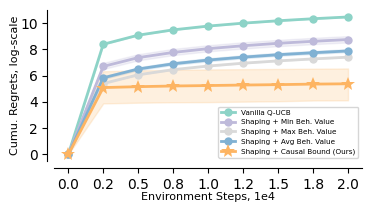

In [4]:
# Draw experiment figures
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from causal_rl.algo.reward_shaping.constants import MAX_EPISODES, SEEDS

env_name = 'Custom-LavaCrossing-extreme-v0'
palette = sns.color_palette('Set3')

METHOD_NAMES = ['Vanilla Q-UCB', 'Shaping + Min Beh. Value', 'Shaping + Max Beh. Value', 'Shaping + Avg Beh. Value', 'Shaping + Causal Bound (Ours)']
COLORS = [palette[0], palette[2], palette[8], palette[4], palette[5]]


print(env_name)
sns.reset_defaults()
stepsize = MAX_EPISODES[env_name]//8
max_y = 0
for i, method in enumerate(METHOD_NAMES):
    full_regret = []
    full_seeds = []
    full_steps = []
    for seed in SEEDS:
        with open(f'regrets/REG-{env_name}-{method}-{seed}.json', 'r') as f:
            regret = json.load(f)
            max_y = max(max(np.log(regret)), max_y)
            regret[0] = 1 #for better visuals in log scale
            full_regret += regret[::stepsize-1]
            full_seeds += [seed,]*len(regret[::stepsize-1])
            full_steps += list(range(len(regret)))[::stepsize-1]
    regret = pd.DataFrame(data={'step':full_steps, 'reg':np.log(full_regret), 'seed':full_seeds}).sort_values('step', ascending=True)
    # shift the x-axis a little bit to get the last element
    marker = 'o' if method != 'Shaping + Causal Bound (Ours)' else '*'
    markersize = 6 if method != 'Shaping + Causal Bound (Ours)' else 10
    alpha = 1.0 if method != 'Shaping + Causal Bound (Ours)' else 1.0
    ax = sns.lineplot(data=regret, x='step', y='reg', label=f'{method}', legend='brief', linewidth=2, color=COLORS[i], marker=marker, markersize=markersize, mew=0, alpha=alpha)   


ax.set_xlabel('Environment Steps, 1e'+str(len(str(MAX_EPISODES[env_name])[1:])), fontsize=8, labelpad=0)
ax.set_ylabel('Cumu. Regrets, log-scale', fontsize=8, labelpad=0)

magnitude = 10**int(f'{MAX_EPISODES[env_name]:.1E}'.split('+')[1])
ax.set_xticks(range(0, MAX_EPISODES[env_name]+1, stepsize), labels=[f'{i/magnitude:.1f}' for i in range(0, MAX_EPISODES[env_name]+1, stepsize)], fontsize=12)
ax.set_yticks(range(0, int(np.ceil(max_y))+1, 2), labels=[str(i) for i in np.arange(0, int(np.ceil(max_y))+1, 2)], fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='10') 
# Calculate maximum label length
max_label_length = max(len(label.get_text()) for label in plt.legend().get_texts())
# Adjust font size based on label length
fontsize = 11 - max_label_length * 0.2
plt.legend(fontsize=fontsize)

sns.despine(offset=5)
sns.set_theme(font_scale=8)
plt.tight_layout()
plt.show()

We can see clearly that our proposed method (orange curve) outperforms others.

In [6]:
# Render videos of the trained agents
# By default, video outputs will be saved to dir_of_this_notebook/videos/
import cv2
from causal_gym.envs.lava_minigrid import Coin
from minigrid.core.constants import TILE_PIXELS

# Available choices
# ['No Shaping', 'Shaping + Causal Bound (Ours)', \
#  'Shaping + Min Beh. Value', 'Shaping + Max Beh. Value', 'Shaping + Avg Beh. Value']"
method = 'Shaping + Causal Bound (Ours)'
env_name = 'Custom-LavaCrossing-extreme-v0'

SEED = SEEDS[0]
NAMES = [
    'No Shaping', 
    'Shaping + Causal Bound (Ours)', 
    'Shaping + Min Beh. Value', 
    'Shaping + Max Beh. Value', 
    'Shaping + Avg Beh. Value'
]

WIND_ONLY = False
POLICY_ONLY = False
assert not WIND_ONLY and not POLICY_ONLY, 'cant set both "wind_only" and "policy_only" to true at the same time!'

# 32 * x
RENDER_TILE_SIZE = TILE_PIXELS * 5

# Video maker
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Rendering environment set up
KWARGS[env_name]['agent_start_pos'] = (1,1)
KWARGS[env_name]['max_episode_steps'] = 50
render_env = gym.make(env_name, agent_pov=False, render_mode='rgb_array', highlight=False, tile_size=RENDER_TILE_SIZE, **KWARGS[env_name])
render_env = MiniGridActionRemapWrapper(WindyMiniGridPCH(env=render_env, show_wind=False, wind_dist=WIND_DIST[env_name]))

# Load up policy
with open(f'values/UCBQ-{env_name}-{method}-{SEED}.json', 'r') as f:
    qtable = json.load(f)
    qtable = np.array(qtable)
mappings = {state: np.argmax(qtable[tuple(state)+(slice(None),)]) \
        for state in np.ndindex(tuple(render_env.state_space)) \
            if render_env.grid.get(*state) is None or isinstance(render_env.grid.get(*state), (Coin, ))}

# Run the env and get the episode renderings
print(f'Running policy {method} in {env_name}...')
obs_seq = []
term, trunc = False, False
s, _ = render_env.reset(seed=SEED)
obs = render_env.render(action_todo=mappings[s])
obs_seq.append(obs)
while not (term or trunc):
    sp, r, term, trunc, info = render_env.do(lambda x: mappings[s])
    assert sp == render_env.agent_pos, f'{sp} {render_env.agent_pos} {s} {mappings[s]}'
    next_act = mappings[sp] if not (term or trunc) else None
    obs = render_env.render(action_todo=next_act)
    obs_seq.append(obs)
    s = sp

# Make the video and save
print(f'Rendering episode video for {method} in {env_name}...')
postfix = '-wind' if WIND_ONLY else ''
postfix = '-policy' if POLICY_ONLY else postfix
out = cv2.VideoWriter(f'videos/vis-episode-{env_name}-{method}{postfix}.mp4', fourcc, 1, obs.shape[:2]) 
for f in obs_seq:
    out.write(cv2.cvtColor(f, cv2.COLOR_RGB2BGR))
out.release() 

Running policy Shaping + Causal Bound (Ours) in Custom-LavaCrossing-extreme-v0...
Rendering episode video for Shaping + Causal Bound (Ours) in Custom-LavaCrossing-extreme-v0...
